In [3]:
import matplotlib.pyplot as plt
import numpy as np
#import qutip as qt
#from scipy import ndimage, misc
#from ifigures import *
#from ifigures.my_plots import *
#from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from scipy.linalg import kron, eig
import time

In [4]:
import matplotlib.colors as mcolors
import colorsys


#: Durham colour scheme
cDUp = "#7E317B"  # Palatinate Purple
cDUpp =  "#D8ACF4"  # Light purple

cDUb = "#006388"  # Blue
cDUbb = "#91B8BD"  # Mid Blue
cDUbbb = "#C4E5FA"  # Light Blue
cDUbbbb = "#00AEEF"

cDUsky = "#A5C8D0"  # sky blue

cDUo = "#9FA161"  # Olive Green

cDUr = "#AA2B4A"  # Red
cDUrr = "#BE1E2D"
cDUy = "#E8E391" #  Yellow

cDUp = "#C43B8E" # Pink

cDUk = "#231F20"  # Black
cDUkk = "#002A41" # ink

cDUggg = "#CFDAD1"  # Near White/L. Grey
cDUgg = "#968E85"  # Warm Grey
cDUg = "#6E6464"  # midgrey

In [5]:
def make_colormap(seq):
    """
        Args:
            seq: a sequence of floats and RGB-tuples. The floats should be
                increasing and in the interval (0,1).

        Returns:
            a LinearSegmentedColormap
    """
    seq = [(None, ) * 3, 0.0] + list(seq) + [1.0, (None, ) * 3]
    cdict = {'red': [], 'green': [], 'blue': []}
    for i, item in enumerate(seq):
        if isinstance(item, float):
            r1, g1, b1 = seq[i - 1]
            r2, g2, b2 = seq[i + 1]
            cdict['red'].append([item, r1, r2])
            cdict['green'].append([item, g1, g2])
            cdict['blue'].append([item, b1, b2])
    return mcolors.LinearSegmentedColormap('CustomMap', cdict)


c = mcolors.ColorConverter().to_rgb
rvb = make_colormap([
    c('#b20000'),
    c('#fe7600'), 0.125,
    c('#fe7600'),
    c('#feca00'), 0.25,
    c('#feca00'),
    c('#bcfd00'), 0.375,
    c('#bcfd00'),
    c('#06a133'), 0.5,
    c('#06a133'),
    c('#00f6fd'), 0.625,
    c('#00f6fd'),
    c('#000cfe'), 0.75,
    c('#000cfe'),
    c('#e404fe'), 0.875,
    c('#e404fe'),
    c('#b20000')
])


def getColor(amplitude, phase, maxAmplitude):
    c = rvb(phase / (2. * np.pi))
    scale = amplitude / maxAmplitude
    if scale > 1:
        raise ValueError(
            'Amplitude of the passed complex number is bigger than the'
            ' maximal set amplitudeyter not')
    cc = colorsys.rgb_to_hls(c[0], c[1], c[2])
    c = colorsys.hls_to_rgb(cc[0], cc[1] + (1. - scale) * (1. - cc[1]), cc[2])
    return (c[0], c[1], c[2], 1.0)


def getComplexColor(complexNo, maxAmplitude):
    """
    Get color for a complex numbers

    Represents phase as continous colour wheel, and amplitude as intensity
    of color (zero amplitude = white color), with linear mapping in between.

    Args:
        complexNo (complex float): complex number
        maxAmplitude (float): maximum amplitude in the data set we want to
            represent as colour mapped dots. This is used for normalizing color
            intensity, going from maximal saturation or `maxAmplitude` to
            white color for zero amplitude.

    Returns:
        color as [red, green, blue, alpha]
    """
    angle = np.angle(complexNo)
    if angle < 0:
        angle += 2 * np.pi
    return getColor(np.absolute(complexNo), angle, maxAmplitude)

def white_to_transparency(img):
    """
        Converts white areas of image to transprancy.
    """
    x = np.asarray(img.convert('RGBA')).copy()

    x[:, :, 3] = (255 * (x[:, :, :3] != 255).any(axis=2)).astype(np.uint8)

    return Image.fromarray(x)


In [6]:
def OBE(psi0,Omega,Delta,tmax,npts):
    t=np.linspace(0,tmax,npts)
    rho = (1.0+1.0j)*np.zeros((4,4,npts))    
    Omeff=np.sqrt(Omega**2+Delta**2)
    
    nx=0
    ny=Omega/Omeff
    nz = Delta/Omeff
    
#    nx, ny, nz = 0, 1/np.sqrt(2), 1/np.sqrt(2)

    for i in range(0,npts):
        Theta=Omeff*t[i]
        C=np.cos(Theta/2)
        S=np.sin(Theta/2)
        R=np.array([[C-1.j*nz*S, (-1.j*nx-ny)*S],[(-1.j*nx+ny)*S, C+1.j*nz*S] ])

#        R=np.array([[C-1.j*(Delta/Omeff)*S, -(Omega/Omeff)*S],[(Omega/Omeff)*S, C+1.j*(Delta/Omeff)*S] ])
        
        
        R2=kron(R,R)    
        psi=R2.dot(psi0)   # note that   R2*psi_20 gives something different 
        norm=np.sqrt(abs(psi[0])**2+abs(psi[1])**2+abs(psi[2])**2+abs(psi[3])**2)
        psi=psi/norm   # note that   R2*psi_20 gives something different 
        rho[:,:,i]=kron(psi,np.transpose(psi))
#    rho[0,0,:]=np.clip(rho[0,0,:],0,1) #normalise to 1
#    rho[3,3,:]=np.clip(rho[0,0,:],0,1) #normalise to 1
    return rho

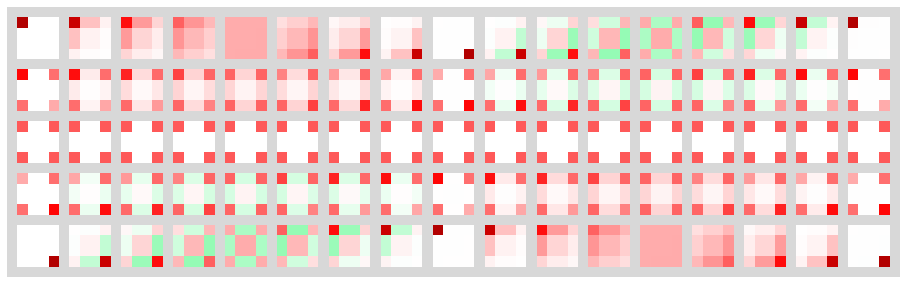

0.851792573928833


In [7]:
start = time.time()
npts=800
tmax=2.0*np.pi*1
t=np.linspace(0,tmax,npts)
mdim = 4 # matrix dimension
time_dim = 17 # no. of times to plot across rows

#time_dim = 40 # no. of times to plot across rows

parameter_dim = 5 # no. of parameter values down columns

h_dim = time_dim*(mdim+1)+1
v_dim = parameter_dim*(mdim+1)+1

R=0.85*np.ones((v_dim,h_dim))
G=0.85*np.ones((v_dim,h_dim))
B=0.85*np.ones((v_dim,h_dim))

fig, ax=plt.subplots(figsize=(16, 8))

for v_index in range(0, parameter_dim): # v_index is no. of rows
    a00=[1.0,np.sqrt(3/4),1/np.sqrt(2),1/np.sqrt(4),0.0]
    a11=[0.0,1/np.sqrt(4),1/np.sqrt(2),np.sqrt(3/4),1.0]
    psi0=np.mat([[a00[v_index]],[0.0],[0.0],[a11[v_index]]])
    Delta=0.0
    Omega=5.0+0.000001
    rho = OBE(psi0,Omega,Delta,tmax,npts)
    for h_index in range(0, time_dim): # h_index is no. of columns
        t_index=10*h_index        
        for col in range (0,mdim):
            for row in range (0,mdim):
                R[(mdim+1)*v_index+1+row,(mdim+1)*h_index+1+col]=getComplexColor(rho[row,col,t_index],1.)[0]
                G[(mdim+1)*v_index+1+row,(mdim+1)*h_index+1+col]=getComplexColor(rho[row,col,t_index],1.)[1]
                B[(mdim+1)*v_index+1+row,(mdim+1)*h_index+1+col]=getComplexColor(rho[row,col,t_index],1.)[2]

RGB=np.dstack((R, G, B))
    
plt.imshow(RGB)
ax.set_axis_off() 
plt.show()

end = time.time()
print(end - start)

In [3]:
a = np.array([[1,2j],[3j,1]])

In [14]:
a.T.conj()

array([[1.-0.j, 0.-3.j],
       [0.-2.j, 1.-0.j]])

SyntaxError: EOL while scanning string literal (<ipython-input-12-b6a83500d30a>, line 1)

In [4]:
a = np.array([1,2])
b = np.array([1,2])
np.outer(a,b)

array([[1, 2],
       [2, 4]])

In [7]:
np.matrix([1,2j]).T

matrix([[1.+0.j],
        [0.+2.j]])